In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from collections import defaultdict
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from multiprocessing.pool import Pool
from matplotlib.ticker import MaxNLocator
plt.style.use('dark_background')

In [2]:
from hhm import *

In [3]:
def V(t):
    return -10 if 2 < t < 22 else -100

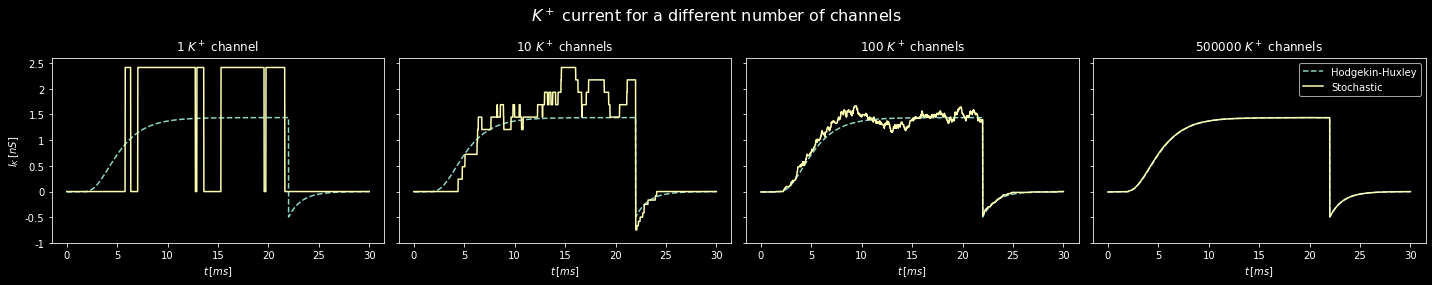

In [235]:
t_max = 30
num_channels = [1, 10, 100, 500000]

fig, axes = plt.subplots(ncols=len(num_channels), figsize=(5*len(num_channels), 4))

for ax, num in zip(axes, num_channels):
    ts, current_hh_K = vc_current_K(V, t_max=t_max)
    ts, current_stochastic_K = stochastic_vc_current(
        KChannels(num), V=V, E=E_K, g=g_K, t_max=t_max
    )

    ax.plot(ts, current_hh_K, label="Hodgekin-Huxley", linestyle="--")
    ax.plot(ts, current_stochastic_K, label="Stochastic")
    ax.set_xlabel(r"$t\, [ms]$")
    ax.set_title(f"{num} $K^+$ channel{'s' if num > 1 else ''}")
    ax.set_ylim((-1000, 2600))

axes[0].set_ylabel(r"$I_{K}\, [nS]$")
for ax in axes[1:]:
    ax.set_yticklabels([])
axes[-1].legend()

axes[0].set_yticks(range(-1000, 2501, 500))
axes[0].set_yticklabels([f"{i:g}" for i in 1e-3 * np.arange(-1000, 2501, 500)])

plt.subplots_adjust(top=0.95)
plt.suptitle("$K^+$ current for a different number of channels", fontsize=16)
plt.tight_layout()
plt.savefig("k", dpi=300)

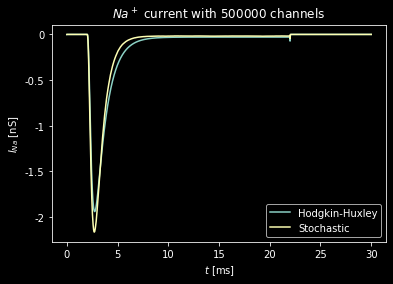

In [246]:
t_max = 30

ts, current_hh_Na = vc_current_Na(lambda t: -10 if 2 < t < 22 else -100, t_max=t_max)
ts, current_stochastic_Na = stochastic_vc_current(NaChannels(500000), V=V, E=E_Na, g=g_Na, t_max=t_max)

plt.plot(ts, current_hh_Na, label="Hodgkin-Huxley")
plt.plot(ts, current_stochastic_Na, label="Stochastic")
plt.title("$Na^+$ current with 500000 channels")
plt.xlabel("$t$ [ms]")
plt.ylabel("$I_{Na}$ [nS]")
plt.yticks(range(-2000, 1, 500), [f"{i:g}" for i in 1e-3 * np.arange(-2000, 1, 500)])
plt.legend()
plt.savefig("na", dpi=300)

In [204]:
def vc_current_data(arg):
    type_, num = arg
    kwargs = {
        "k": {"E": E_K, "g": g_K},
        "na": {"E": E_Na, "g": g_Na},
    }[type_]

    ts, current = stochastic_vc_current(
        KChannels(int(num)) if type_ == "k" else NaChannels(int(num)),
        V=lambda t: -10 if 2 < t < 22 else -100,
        **kwargs,
        t_max=30,
    )
    
    hh = current_hh_K if type_ == "k" else current_hh_Na
    return {"type": type_, "num": num, "mse": np.mean((current - hh) ** 2) / current.size}

In [242]:
with Pool() as p:
    mse_data = p.map(vc_current_data, product(["k", "na"], 10 ** np.arange(0, 6+0.25, 0.25)))
mse_data = pd.DataFrame(mse_data)

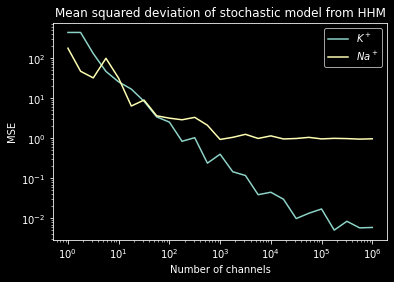

In [244]:
ax = plt.figure().gca()
sns.lineplot(data=mse_data, x="num", y="mse", hue="type", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["$K^+$", "$Na^+$"])
plt.title("Mean squared deviation of stochastic model from HHM")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of channels")
plt.ylabel("MSE")
plt.savefig("mse", dpi=300)

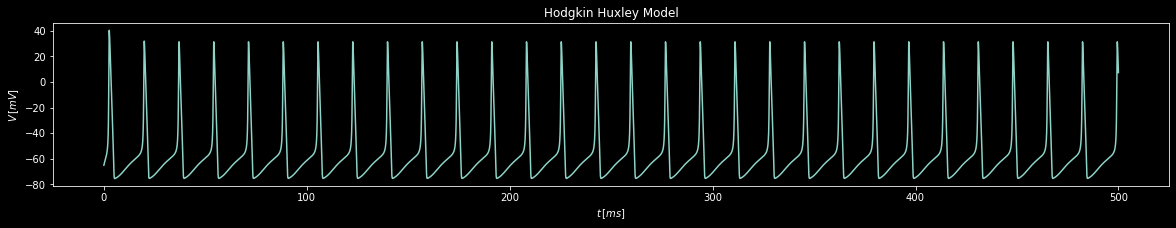

In [237]:
plt.figure(figsize=(20,3))
ax = plt.gca()
hhm(t_max=500, I_e=lambda t: 7).plot(x="t", y="V", legend=False, ax=ax)
ax.ticklabel_format(useOffset=False)
plt.xlabel(r"$t\, [ms]$")
plt.ylabel(r"$V\, [mV]$")
plt.title("Hodgkin Huxley Model")
plt.savefig("hhm", dpi=300)

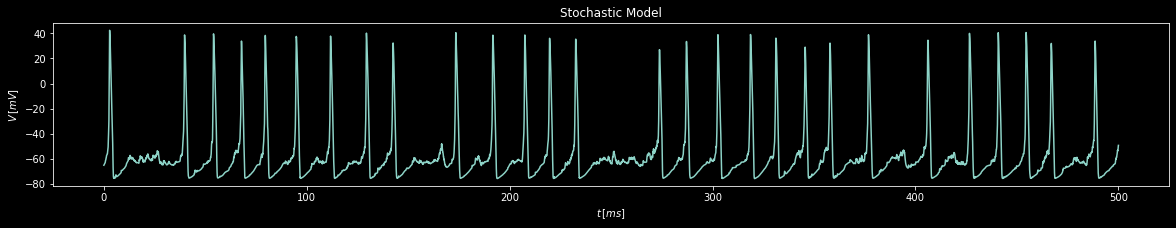

In [232]:
plt.figure(figsize=(20,3))
ax = plt.gca()
stochastic_hhm(t_max=500, I_e=lambda t: 7).plot(x="t", y="V", legend=False, ax=ax)
ax.ticklabel_format(useOffset=False)
plt.xlabel(r"$t\, [ms]$")
plt.ylabel(r"$V\, [mV]$")
plt.title("Stochastic Model")
plt.savefig("stochastic", dpi=300)

In [225]:
# returns a list of 1 / isi for each isi in simulation
def firing_rates(num, I_e, stochastic=True):
    if stochastic:
        data = stochastic_hhm(t_max=500, I_e=lambda t: I_e, num_K=num, num_Na=num)
    else:
        data = hhm(t_max=500, I_e=lambda t: I_e)

    peaks = find_peaks(data["V"], height=0, distance=25)[0]
    t_peaks = data["t"].loc[peaks].to_numpy()

    if peaks.size >= 2:
        isis = t_peaks[1:] - t_peaks[:-1]
        return 1 / isis
    else:
        return [0]

In [226]:
# returns a list of data dicts to be made into a dataframe
def firing_rate_data(arg):
    num, I_e, stochastic = arg
    rates = firing_rates(num, I_e, stochastic)
    datas = []
    for rate in rates:
        datas.append({"num": num, "I_e": I_e, "firing_rate": rate, "stochastic": stochastic})
    return datas

nums = [25000, 5000, 10000]
I_e = np.linspace(0, 25, 26)
I_e_hh = np.linspace(0, 25, 200)
data = []

threads = []
threads.extend(product(nums, I_e, [True]))
threads.extend([("hhm", I, False) for I in I_e_hh])

with Pool() as p:
    data = p.map(firing_rate_data, threads)

data = pd.DataFrame([d for d_ in data for d in d_])

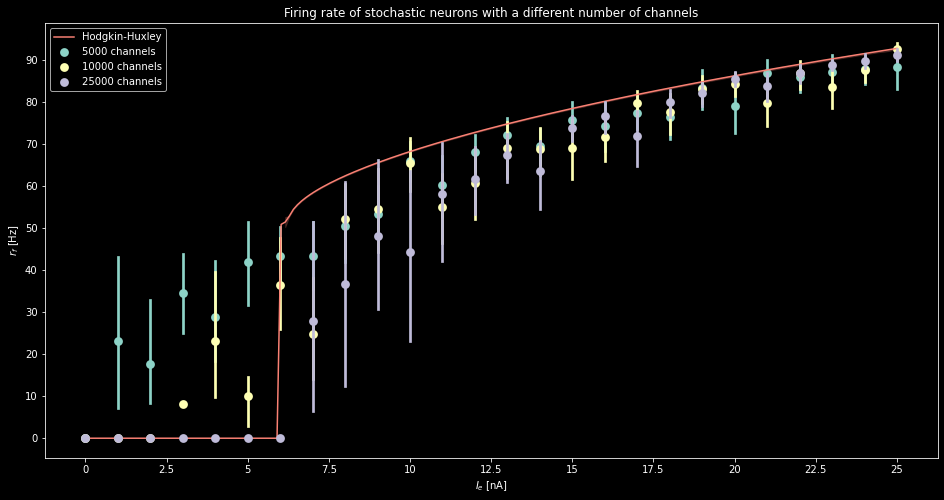

In [240]:
plt.figure(figsize=(16, 8))

sns.pointplot(
    data=data[data["stochastic"] == True],
    x="I_e",
    y="firing_rate",
    hue="num",
    # join=False,
    linestyles="--",
    # ci=False,
)

sns.lineplot(
    data=data[data["stochastic"] == False],
    x="I_e",
    y="firing_rate",
    label="Hodgkin-Huxley",
    color=f"C{len(nums)}",
)

handles, labels = plt.gca().get_legend_handles_labels()
for i in range(len(labels)):
    try:
        n = int(labels[i])
        labels[i] = f"{labels[i]} channels"
    except:
        pass
plt.legend(handles, labels)

plt.xticks(np.arange(0, 26, 2.5), [f"{i:g}" for i in np.arange(0, 26, 2.5)])
plt.xlabel("$I_e$ [nA]")
plt.yticks(np.arange(0, 0.1, 0.01), range(0, 100, 10))
plt.ylabel("$r_f$ [Hz]")
plt.title("Firing rate of stochastic neurons with a different number of channels")
plt.savefig("fi", dpi=300)